# PIERS Data Cleaning

This notebook addresses missing data and other issues in the PIERS BOL data. This work is predominantly exploratory in nature, and some of these processes may eventually move to the ETL step. 

In [1]:
import pandas as pd
import polars as pl
import plotly_express as px
import missingno as msno

#display settings
pd.set_option('display.max_columns', None)

#enable string cache for polars categoricals
pl.enable_string_cache()

Convenience steps:
- create 2-digit hs codes (note this naievely takes the first two digits from the column, which contains multiple hs codes)
- create year and month (e.g., 202305) columns 
- replace zero values with nulls in volume columns
- create voyage_id from voyage number and vessel IMO code. 
- add direction column showing 'import' or 'export' to allow easy merging

In [2]:
#set paths
imports_path = 'data/clean/imports/'
exports_path = 'data/clean/exports/'
#init lazy dataframes
imports_lf = (
    pl.scan_parquet(imports_path+'*.parquet', parallel='columns')
    .with_columns([
        #create 2-digit hs code
        pl.col('hs_code').str.slice(0, length=2).alias('hs_2d'),
        #create year and month columns
        pl.col('date_arrival').dt.year().alias('year'),
        pl.col('date_arrival').dt.strftime('%Y%m').alias('month'),
        #convert zero volume values to null
        pl.col('teus').replace(0,None),
        pl.col('weight').replace(0,None),
        pl.col('qty').replace(0,None),
        #create voyage_id from vessel IMO and voyage number
        (pl.col('vessel_id').cast(pl.Utf8)+'_'+pl.col('voyage_number').cast(pl.Utf8)).cast(pl.Categorical).alias('voyage_id'),
        #create direction column
        pl.lit('import').cast(pl.Categorical).alias('direction')
        ])
    )
exports_lf = (
    pl.scan_parquet(exports_path+'piers_exports_complete.parquet', parallel='columns')
    .with_columns([
        #create 2-digit hs code
        pl.col('hs_code').str.slice(0, length=2).alias('hs_2d'),
        #create year and month columns
        pl.col('date_departure').dt.year().alias('year'),
        pl.col('date_departure').dt.strftime('%Y%m').alias('month'),
        #convert zero volume values to null
        pl.col('teus').replace(0,None),
        pl.col('weight').replace(0,None),
        pl.col('qty').replace(0,None),
        #create voyage_id from vessel IMO and voyage number
        (pl.col('vessel_id').cast(pl.Utf8)+'_'+pl.col('voyage_number').cast(pl.Utf8)).cast(pl.Categorical).alias('voyage_id'),
        #create direction column
        pl.lit('export').cast(pl.Categorical).alias('direction')
        ])
    )

## Notebook functions

In [3]:
#fill nulls in volume cols with mean
def fill_volume(lf):
    '''ad hod function to fill volume columns with their means'''
    return (
        lf
        .with_columns([
            pl.col('teus').replace(0,None).fill_null(strategy='mean'),
            pl.col('weight').replace(0,None).fill_null(strategy='mean'),
            pl.col('qty').replace(0,None).fill_null(strategy='mean')
            ])
        )

#plotly graph inspecting nulls over time by group
def nulls_over_time_plotly(data_lf, group_var, time_var, value_var, title=False):
    '''
    Plots proportion of null values over time by group.
    INPUTS:
        data_lf - polars lazyframe containing the relevant data
        group_var - str - the name of the column by which to group
        time_var - str - the name of the time column (e.g., year, month) over which values will be counted
        value_var - str - the name of the column containing the variable in question
        title (default=False) - str - the title of the graph
    OUTPUT:
        a plotly express figure
    DEPENDS ON:
        polars
        plotly express 
    '''
    df = (
        #select relevant columns
        data_lf.select([group_var, time_var, value_var])
        #group by, creating null count and non-null count cols
        .group_by(group_var, time_var)
        .agg([pl.col(value_var).null_count().alias('null_count'),
                pl.col(value_var).count().alias('count')])
        #compute percent null and fill new column
        .with_columns((pl.col('null_count')/(pl.col('count')+pl.col('null_count'))).alias('null_percent'))
        #cast group col to string to allow sensible ordering of legend
        .cast({group_var:pl.Utf8})
        #sort by date (to allow proper visualization of lines) and group (for legend ordering) 
        .sort(time_var, group_var)
    ).collect()
    #plot
    fig = px.line(
        data_frame=df,
        x=time_var, y='null_percent',
        color=group_var,
        title= 'Count of nulls over time by source frame.' if not title else title
    )
    fig.show()

#plotly graph inspecting nulls by group
def nulls_by_group_plotly(data_lf, group_var, value_var, title=False):
    '''Plots proportion of null values in the given groups'''
    df = (
        data_lf.select([group_var, value_var])
        .group_by(group_var)
        .agg([pl.col(value_var).null_count().alias('null_count'),
                pl.col(value_var).count().alias('count')])
        .with_columns((pl.col('null_count')/(pl.col('count')+pl.col('null_count'))).alias('null_percent'))
        .cast({group_var:pl.Utf8})
        .sort('null_percent', descending=True)
    ).collect()
    #plot
    fig = px.bar(
        data_frame=df,
        x=group_var, y='null_percent',
        title= 'Null percent by group.' if not title else title
    )
    fig.show()

#fill nulls over groups given a single unique value per group
def fill_nulls_by_group(data_lf, group_vars, val_var):
    '''Fills null values by group if and only if the val_var for that group contains exactly one non-null unique value.
    INPUTS:
        data_lf - polars lazyframe containing the relevant data
        group_vars - iterable - the names of the columns by which groups will be created
        val_var - string - the name of the column in which nulls will be filled
    OUTPUT:
        filled_lf - the resultant lazyframe 
    DEPENDS ON:
        polars - current version written in polars 0.20.1
    '''
    filled_lf = (
        data_lf.with_columns(
            #if the group contains exactly one unique value: 
            pl.when(pl.col(val_var).drop_nulls().unique(maintain_order=True).len().over(group_vars)==1)
            #then fill the group with that value
            .then(pl.col(val_var).fill_null(pl.col(val_var).drop_nulls().unique(maintain_order=True).first().over(group_vars)))
            #otherwise do nothing
            .otherwise(pl.col(val_var))
            )
        )
    return filled_lf

## Missing Data


Missing Values Matrix for Exports. 
The vertical axis corresponds to date, with earliest at the top.  
Note the daily aggregation counts the row as non-null if any value that day is non-null.


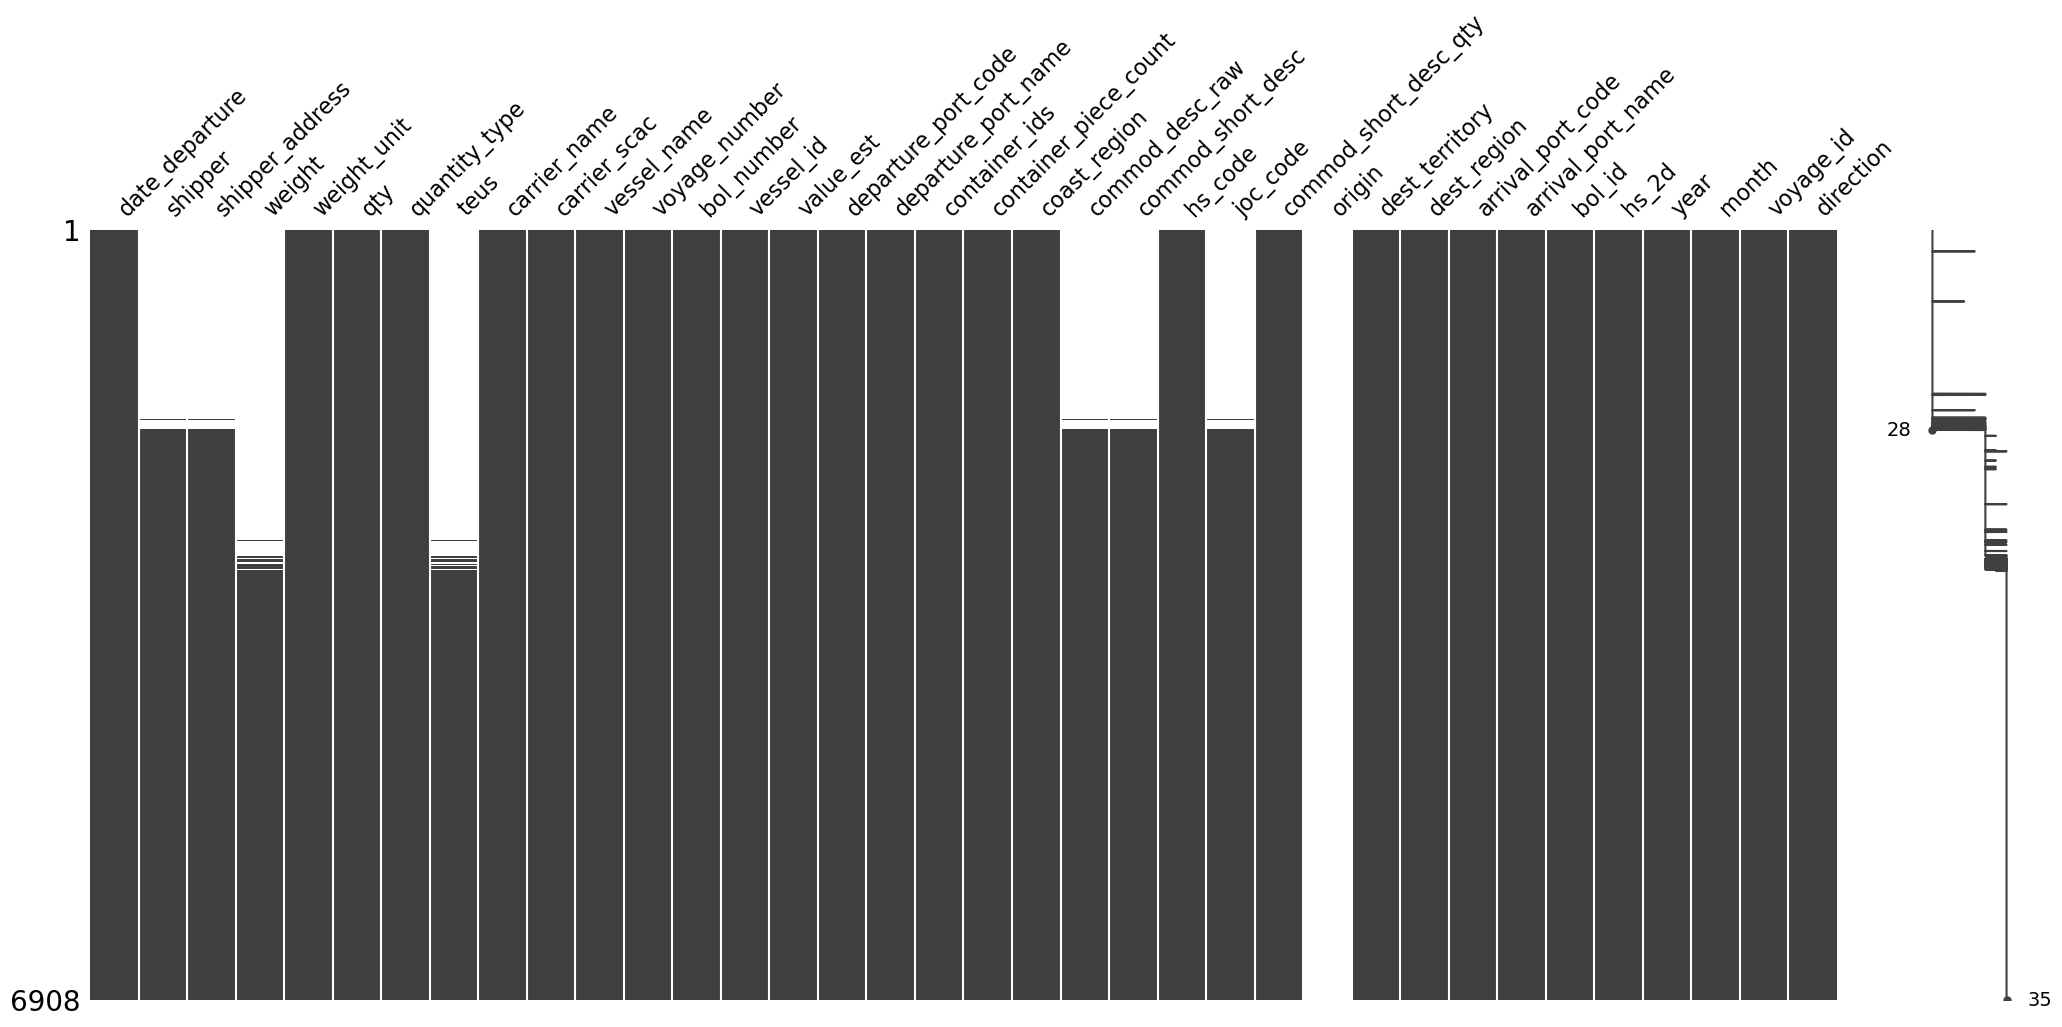

In [4]:
print('Missing Values Matrix for Exports. \nThe vertical axis corresponds to date, with earliest at the top.  \nNote the daily aggregation counts the row as non-null if any value that day is non-null.')
msno.matrix(
    exports_lf
    #convert all columns except date to boolean False=null
    .with_columns(pl.all().exclude('date_departure').is_not_null())
    #aggregate by day to stay within visualization limitations 
    .group_by('date_departure').sum()
    .sort('date_departure')
    #convert False values back to null 
    .with_columns(pl.all().replace(0,None))
    .collect()
    .to_pandas()
    );

Missing Values Matrix for Imports. 
The vertical axis corresponds to date, with earliest at the top. 
Note the daily aggregation counts the row as non-null if any value that day is non-null.


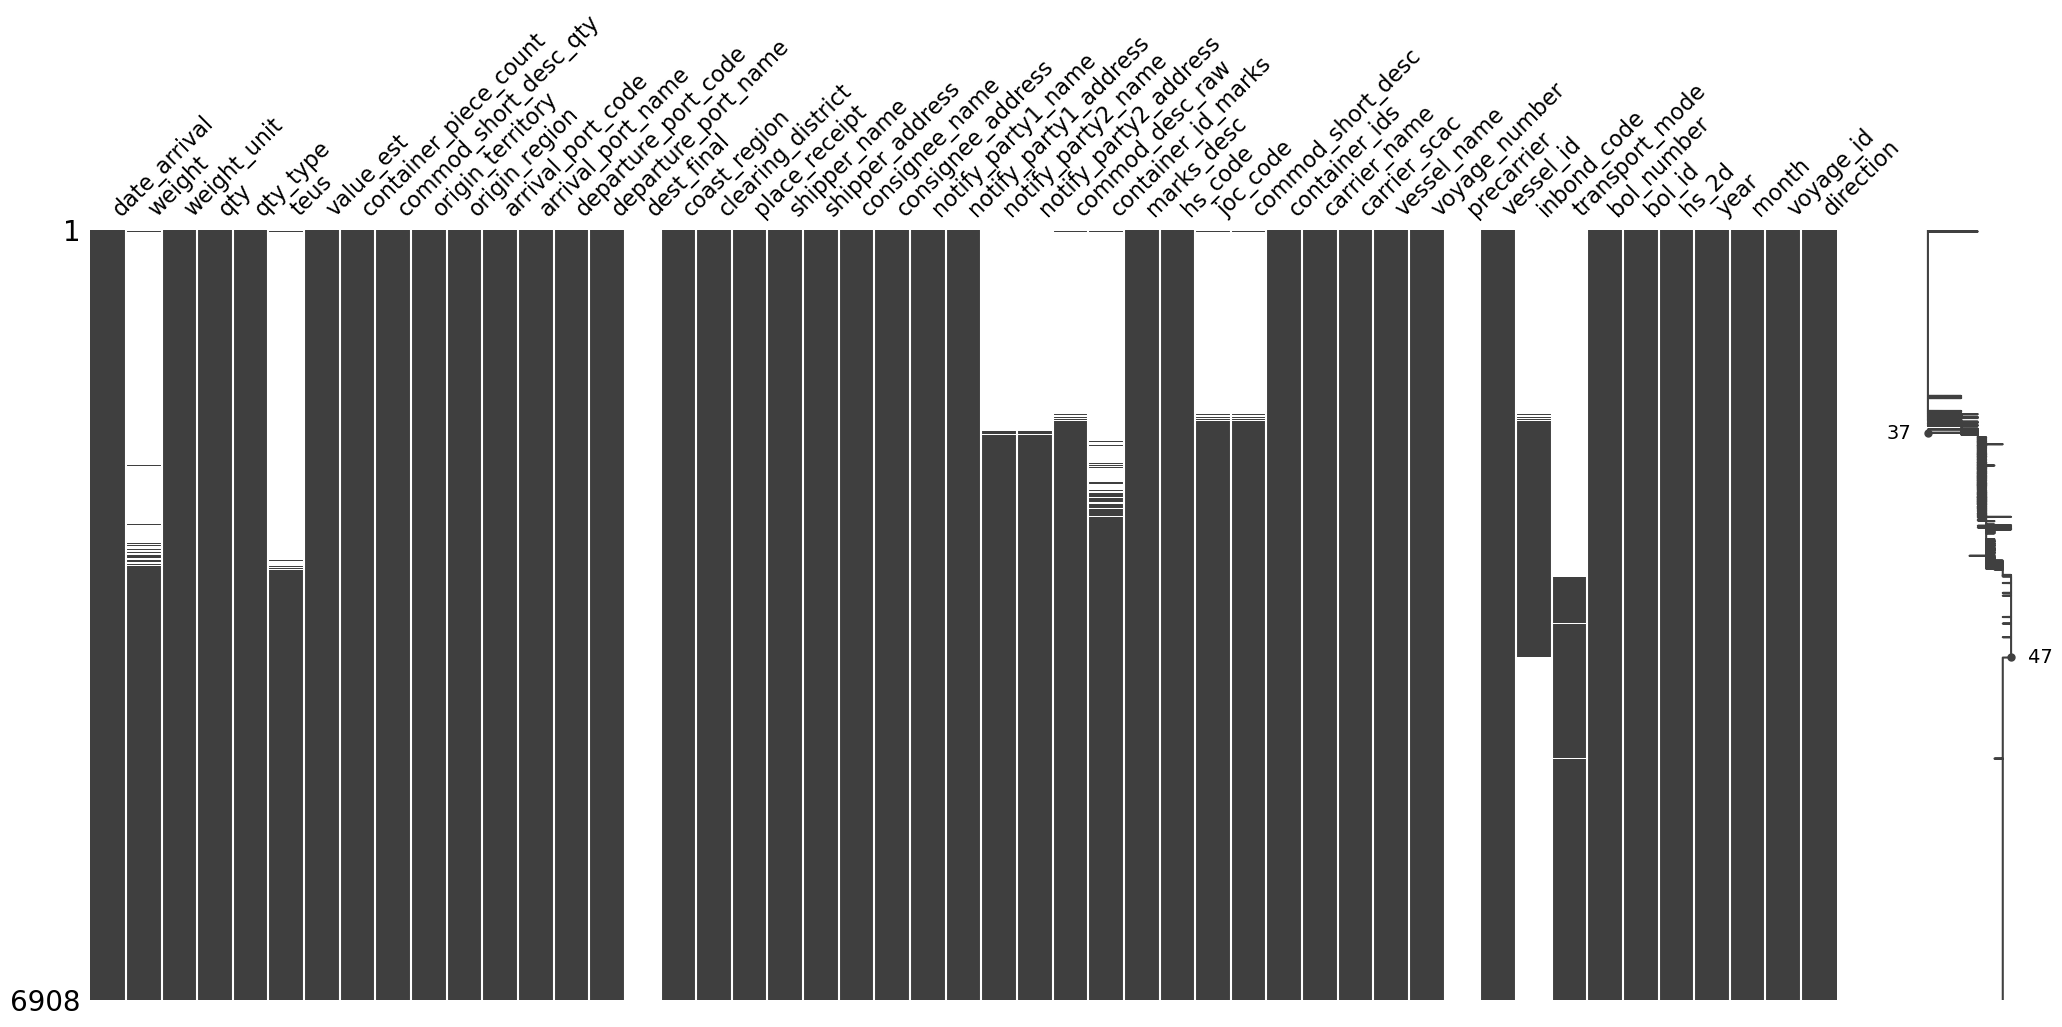

In [5]:
print('Missing Values Matrix for Imports. \nThe vertical axis corresponds to date, with earliest at the top. \nNote the daily aggregation counts the row as non-null if any value that day is non-null.')
msno.matrix(
    imports_lf
    #convert all columns except date to boolean False=null
    .with_columns(pl.all().exclude('date_arrival').is_not_null())
    #aggregate by day to stay within visualization limitations 
    .group_by('date_arrival').sum()
    .sort('date_arrival')
    #convert False values back to null 
    .with_columns(pl.all().replace(0,None))
    .collect()
    .to_pandas()
    );

### Zero values in TEU and other volume columns

For the time being, we fill the zero (i.e., missing) volume data with the mean from non-zero observations. This step is expected to change as beter metadata is gathered. 

In [6]:
imports_lf = fill_volume(imports_lf)
exports_lf = fill_volume(exports_lf)    

### Missing Vessel and Voyage IDs

Identifying unique vessels and voyages is critical to studying how long each vessel remains in port, how often carriers utilize alliances (e.g., what proportion of a vessel's cargo is from another carrier), and other quality metrics. The issue is especially concerning given the high proportion (~30% in some time periods) of missing data, as can be seen below.

In [7]:
lf = pl.concat(
    [imports_lf.select('direction', 'month', 'vessel_id'),
    exports_lf.select('direction', 'month', 'vessel_id')]
)

nulls_over_time_plotly(
    data_lf=lf,
    group_var='direction',
    time_var='month',
    value_var='vessel_id',
    title='Proportion of Missing Vessel IDs over time (original data).')

In [8]:
lf = pl.concat(
    [imports_lf.select('direction', 'month', 'vessel_name'),
    exports_lf.select('direction', 'month', 'vessel_name')]
)

nulls_over_time_plotly(
    data_lf=lf,
    group_var='direction',
    time_var='month',
    value_var='vessel_name',
    title='Proportion of Missing Vessel Names over time (original data).')

In [9]:
lf = pl.concat(
    [imports_lf.select('direction', 'month', 'voyage_id'),
    exports_lf.select('direction', 'month', 'voyage_id')]
)

nulls_over_time_plotly(
    data_lf=lf,
    group_var='direction',
    time_var='month',
    value_var='voyage_id',
    title='Proportion of Missing Voyage IDs over time (original data).')

Assuming each vessel only has one sailing to/from a given port per day, we can fill in missing vessel_id (voyage_id) based on other bols that used the same port the same day on the same voyage (vessel).

In [11]:
#fill nulls by vessel name
imports_lf = fill_nulls_by_group(imports_lf, group_vars='vessel_name', val_var='vessel_id')
exports_lf = fill_nulls_by_group(exports_lf, group_vars='vessel_name', val_var='vessel_id')

#fill nulls by vessel name and voyage id 
imports_lf = fill_nulls_by_group(imports_lf, group_vars=['vessel_name', 'voyage_id'], val_var='vessel_id')
exports_lf = fill_nulls_by_group(exports_lf, group_vars=['vessel_name', 'voyage_id'], val_var='vessel_id')

In [12]:
lf = pl.concat(
    [imports_lf.select('direction', 'month', 'vessel_id'),
    exports_lf.select('direction', 'month', 'vessel_id')]
)

nulls_over_time_plotly(
    data_lf=lf,
    group_var='direction',
    time_var='month',
    value_var='vessel_id',
    title='Proportion of Missing Vessel IDs over time (partially filled data).')

In [ ]:
imports_lf.limit(10).collect()

weight,weight_unit,qty,qty_type,teus,value_est,date_arrival,container_piece_count,commod_short_desc_qty,origin_territory,origin_region,arrival_port_code,arrival_port_name,departure_port_code,departure_port_name,dest_final,coast_region,clearing_district,place_receipt,shipper_name,shipper_address,consignee_name,consignee_address,notify_party1_name,notify_party1_address,notify_party2_name,notify_party2_address,commod_desc_raw,container_id_marks,marks_desc,hs_code,joc_code,commod_short_desc,container_ids,carrier_name,carrier_scac,vessel_name,voyage_id,precarrier,vessel_id,inbond_code,transport_mode,bol_number,bol_id,hs_2d,year,month,direction
f64,cat,f64,cat,f64,f64,datetime[μs],i32,str,cat,cat,cat,cat,cat,cat,cat,cat,cat,cat,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,cat,cat,str,str,f64,i32,f64,cat,str,str,str,i32,str,str
76862.448175,"""KG""",1526.0,"""CTN""",2.196793,0.0,2005-12-29 00:00:00,1,"""1526""","""CHINA (MAINLAN…","""NORTH EAST ASI…","""4909""","""SAN JUAN""","""57047""","""QINGDAO""",null,"""CARIBBEAN""",null,"""QINGDAO""","""ITAL SPORTS""","""47 2ND FLOOR G…","""ELEVEN ELEVEN""",null,"""ECONOCARIBE""","""2401 NW 69TH S…",null,null,null,null,"""ZZ""","""611599""",null,null,"""CLHU8366831""","""UNAVAILABLE ON…","""ZZZZ""","""MIZAR""","""32""",null,9295505,null,null,"""GLPSJA11338""","""ZZZZ_GLPSJA113…","""61""",2005,"""200512""","""import"""
76862.448175,"""KG""",1585.276648,"""-1""",2.196793,0.0,2005-10-12 00:00:00,0,"""0""","""HONG KONG""","""NORTH EAST ASI…","""4601""","""NEW YORK""","""58201""","""HONG KONG""",null,"""EAST""",null,"""HONG KONG""","""FORMASTERCONTA…",null,"""FORMASTERCONTA…",null,"""FORMASTERCONTA…",null,null,null,null,null,null,"""009669""",null,null,null,"""HANJIN SHIPPIN…","""HJSC""","""CHESAPEAKE BAY…",null,null,9280811,null,null,"""MSTB753117HJSC…","""HJSC_MSTB75311…","""00""",2005,"""200510""","""import"""
76862.448175,"""KG""",59.0,"""PKG""",2.196793,0.0,2005-10-12 00:00:00,1,"""59""","""CHINA (MAINLAN…","""NORTH EAST ASI…","""4601""","""NEW YORK""","""58023""","""BUSAN""",null,"""EAST""",null,"""SHANGHAI""","""WANVOG FURNITU…","""NO.8, TAIHU SO…","""ASHLEY FURNITU…","""1 ASHLEY WAY""","""ASHLEY FURNITU…","""1 ASHLEY WAY""",null,null,null,null,"""40""","""9401""",null,null,"""CLHU4278028""","""ZIM CONTAINER""","""ZIML""","""ZIM BARCELONA""","""6""",null,9280835,null,null,"""SNH5808843""","""ZIML_SNH580884…","""94""",2005,"""200510""","""import"""
76862.448175,"""KG""",80.0,"""PCS""",2.196793,0.0,2005-03-30 00:00:00,0,"""80""","""SRI LANKA (CEY…","""INDIAN SUB CON…","""1601""","""CHARLESTON""","""52330""","""SALALAH""",null,"""EAST""","""CHARLESTON, S.…","""COLOMBO""","""LOAD STAR""","""4 HUNUPITIYA R…","""ORDER OF SHIPP…",null,"""OTR WHEEL ENGI…","""218 OLD LINDAL…",null,null,null,null,null,"""730791""",null,null,null,"""MAERSK LINE""","""MLSL""","""MAERSK MISSOUR…","""504""",null,9155121,null,null,"""CMB300747""","""MLSL_CMB300747…","""73""",2005,"""200503""","""import"""
76862.448175,"""KG""",40.0,"""PKG""",2.196793,0.0,2005-05-27 00:00:00,1,"""40""","""REPUBLIC OF KO…","""NORTH EAST ASI…","""2709""","""LONG BEACH""","""58023""","""BUSAN""",null,"""WEST""","""LOS ANGELES, C…","""BUSAN""","""SAMSUNG""","""CPO BOX 2775""","""SAMSUNG""","""2498 ROLL DR""","""SAMSUNG""","""2498 ROLL DR""",null,null,null,null,"""40""","""854800""",null,null,"""HJCU1219850""","""HANJIN SHIPPIN…","""HJSC""","""HANJIN PHOENIX…","""35""",null,9232084,null,null,"""PUSA05765703""","""HJSC_PUSA05765…","""85""",2005,"""200505""","""import"""
76862.448175,"""KG""",19.0,"""BLS""",2.196793,0.0,2005-06-07 00:00:00,1,"""19""","""CHINA (MAINLAN…","""NORTH EAST ASI…","""3002""","""TACOMA""","""57035""","""SHANGHAI""",null,"""WEST""","""SEATTLE, WASHI…","""SHANGHAI""","""WINWORTH INTER…","""42-56 KWONG WA…","""UNIWORTH""","""ROCKET 4WEST 3…","""UNIWORTH""","""ROCKET 4WEST 3…",null,null,null,null,"""LC""","""5212""",null,null,"""HDMU6322731""","""HYUNDAI""","""HYMM""","""HYUNDAI CHALLE…","""512""",null,8417948,n

In [ ]:
#fill vessel names and ids based on unique sailings
imports_lf = fill_nulls_by_group(imports_lf, group_vars=['arrival_port_code', 'date_arrival', 'voyage_id'], val_var='vessel_id')
imports_lf = fill_nulls_by_group(imports_lf, group_vars=['arrival_port_code', 'date_arrival', 'voyage_id'], val_var='vessel_name')
exports_lf = fill_nulls_by_group(exports_lf, group_vars=['departure_port_code', 'date_departure', 'voyage_id'], val_var='vessel_id')
exports_lf = fill_nulls_by_group(exports_lf, group_vars=['departure_port_code', 'date_departure', 'voyage_id'], val_var='vessel_name')
#fill voyage ids based on similar logic
exports_lf = fill_nulls_by_group(exports_lf, group_vars=['departure_port_code', 'date_departure', 'vessel_id'], val_var='voyage_id')
exports_lf = fill_nulls_by_group(exports_lf, group_vars=['departure_port_code', 'date_departure', 'vessel_name'], val_var='voyage_id')
imports_lf = fill_nulls_by_group(imports_lf, group_vars=['arrival_port_code', 'date_arrival', 'vessel_id'], val_var='voyage_id')
imports_lf = fill_nulls_by_group(imports_lf, group_vars=['arrival_port_code', 'date_arrival', 'vessel_name'], val_var='voyage_id')
#fill nulls when vessel name-id pairs are available 
imports_lf = fill_nulls_by_group(imports_lf, group_vars='vessel_name', val_var='vessel_id')
exports_lf = fill_nulls_by_group(exports_lf, group_vars='vessel_name', val_var='vessel_id')

#fill nulls in vessel_id based on voyage id -- NOTE this may overfill vessel_id


In [36]:
sailings_df = pl.concat(
    [exports_lf.select('year', 'carrier_scac', 'voyage_id', 'vessel_id', 'departure_port_code', 'date_departure', 'bol_id', 'direction'),
    imports_lf.select('year', 'carrier_scac', 'voyage_id', 'vessel_id', 'arrival_port_code', 'date_arrival', 'bol_id', 'direction')],
    how='diagonal'
    ).collect()

In [37]:
sailings_by_voyageid_df = (
    sailings_df.filter(pl.col('vessel_id').is_null())
    .group_by('carrier_scac', 'voyage_id')
    .agg(
        pl.col('vessel_id').drop_nulls().unique().alias('vessels'),
        pl.col('departure_port_code').drop_nulls().unique().alias('departure_ports'),
        pl.col('arrival_port_code').drop_nulls().unique().alias('arrival_ports'),
        pl.col('bol_id').drop_nulls().unique().alias('bols')
        )
    .with_columns(
        pl.col('vessels').list.len().alias('n_vessels'),
        pl.col('departure_ports').list.len().alias('n_departure_ports'),
        pl.col('arrival_ports').list.len().alias('n_arrival_ports'),
        pl.col('bols').list.len().alias('n_bols')
        )
)

In [38]:
sailings_by_voyageid_df.sort('n_bols', descending=True).head(20)

carrier_scac,voyage_id,vessels,departure_ports,arrival_ports,bols,n_vessels,n_departure_ports,n_arrival_ports,n_bols
cat,str,list[i32],list[cat],list[cat],list[str],u32,u32,u32,u32
"""MLSL""",null,[],"[""1601"", ""2704"", … ""3127""]",[],"[""MLSL_912202326"", ""MLSL_209807642"", … ""MLSL_203809912""]",0,25,0,106252
"""SEAU""",null,[],"[""1601"", ""2704"", … ""1501""]",[],"[""SEAU_586282302"", ""SEAU_SLN025514"", … ""SEAU_SLN169161""]",0,21,0,98027
"""MAEU""","""1005""",[],"[""1601"", ""2704"", … ""1901""]","[""1601"", ""2704"", … ""1901""]","[""MAEU_SMMBSMHKGS025909"", ""MAEU_MAEU551549232"", … ""MAEU_HNLTSZA1004845AB""]",0,13,12,27961
"""MAEU""","""1003""",[],"[""1601"", ""2704"", … ""1901""]","[""1601"", ""2704"", … ""1901""]","[""MAEU_MAEU555494498"", ""MAEU_550077601"", … ""MAEU_550423232""]",0,13,11,27800
"""MATS""","""007E""",[],[],"[""2709"", ""0005"", ""3201""]","[""MATS_SWOE000001562715"", ""MATS_PGCVMZ6779983"", … ""MATS_SWOE000001810171""]",0,0,3,27042
"""OOLU""","""E012""",[],[],"[""2811"", ""2709""]","[""OOLU_IEGL7356442"", ""OOLU_IEGL7464796"", … ""OOLU_IEGL7150408""]",0,0,2,26992
"""MATS""","""017E""",[],[],"[""2811"", ""2709""]","[""MATS_IBCV13321976829"", ""MATS_IBCV400722270789"", … ""MATS_IBCV13321980391""]",0,0,2,25245
"""ZIMU""","""14E""",[],"[""2704"", ""2811"", … ""4909""]","[""1601"", ""2704"", … ""1501""]","[""ZIMU_IBRN5T7XN6HTJ917"", ""ZIMU_IBRN91KY00A086IZ"", … ""ZIMU_IBRN0JV937PWKTC3""]",0,4,14,24688
"""ONEY""","""013E""",[],"[""1601"", ""4601"", … ""2002""]","[""1601"", ""2704"", … ""1703""]","[""ONEY_ONEYPNHV01689935"", ""ONEY_NMCLKKDET193075"", … ""ONEY_ONEYHKGV42865802""]",0,7,9,20414


In [ ]:
px.histogram(
    data_frame=sailings_by_voyageid_df.filter(pl.col('n_vessels')<20),
    x='n_vessels',
    title='Number of unique vessels per voyage_id'
    )

In [ ]:
sailings_by_voyageid_df.filter(pl.col('n_vessels')>1).describe()

In [ ]:
nulls_over_time_plotly(
    data_lf=imports_lf,
    group_var='direction',
    time_var='month',
    value_var='vessel_id',
    title='Proportion of Missing Vessel IDs over time (filled data).'
)

In [ ]:
nulls_over_time_plotly(
    data_lf=exports_lf,
    group_var='direction',
    time_var='month',
    value_var='vessel_id',
    title='Proportion of Missing Vessel IDs over time (filled data).'
)

In [ ]:
nulls_over_time_plotly(
    data_lf=exports_lf,
    group_var='direction',
    time_var='month',
    value_var='voyage_id',
    title='Proportion of Missing Vessel IDs over time (filled data).'
)

In [ ]:
nulls_over_time_plotly(
    data_lf=imports_lf,
    group_var='direction',
    time_var='month',
    value_var='voyage_id',
    title='Proportion of Missing Voyage IDs over time (filled data).'
)

In [ ]:
imports_lf.filter(pl.col('vessel_id').is_null()).select('voyage_id').collect().to_series().value_counts().sort('count')

In [ ]:
exports_lf.select('voyage_id').sort('voyage_id').collect().to_series().value_counts()

How much volume is traded with missing vessel info?

want: proportion of total volume (TEUs) imported with missing vessel_id 

In [ ]:
lf = (
    imports_lf.select('month', 'vessel_id', 'teus')
    .with_columns(pl.col('vessel_id').is_not_null())
    .group_by('month', 'vessel_id')
    .agg(pl.col('teus').sum())
)

In [ ]:
df = (
    lf.collect()
    .pivot(values='teus', index='month', columns='vessel_id', aggregate_function='sum')
    .with_columns((pl.col('false')/(pl.col('true')+pl.col('false'))).alias('prop_missing'))
    .sort('month')
)

In [ ]:
px.line(data_frame=df, x='month', y='prop_missing', title='Proportion of Total TEUs traded under bols with missing vessel_id')

## Route IDs

Create route ID column from arrival and departure port codes. 

In [ ]:
#create route_id column
imports_lf = (
    imports_lf.with_columns(
        (pl.col('departure_port_code').cast(pl.Utf8)+'_'+pl.col('arrival_port_code').cast(pl.Utf8))
        .cast(pl.Categorical)
        .alias('route_id')
        ))
exports_lf = (
    exports_lf.with_columns(
        (pl.col('departure_port_code').cast(pl.Utf8)+'_'+pl.col('arrival_port_code').cast(pl.Utf8))
        .cast(pl.Categorical)
        .alias('route_id')
        ))

## Days in port

For each arrival, we want to know how many days the ship stays in port before departing. 


In [ ]:
ex_lf = (
    exports_lf.select('voyage_id', 'vessel_id', 'date_departure', 'departure_port_code', 'route_id')
    .rename({'voyage_id':'export_voyage_id'})
    .with_columns((pl.col('date_departure').cast(pl.Utf8)+'_'+pl.col('vessel_id').cast(pl.Utf8)+'_'+pl.col('departure_port_code').cast(pl.Utf8)).alias('departure_id'))
    )
im_lf = (
    imports_lf.select('voyage_id', 'vessel_id', 'date_arrival', 'arrival_port_code', 'route_id')
    .rename({'voyage_id':'import_voyage_id'})
    .with_columns((pl.col('date_arrival').cast(pl.Utf8)+'_'+pl.col('vessel_id').cast(pl.Utf8)+'_'+pl.col('arrival_port_code').cast(pl.Utf8)).alias('arrival_id'))
    )

lf = ex_lf.join(im_lf, on='voyage_id')

## Export Clean data to parquet


In [ ]:
#piers_lf.sink_parquet('data/piers_clean.parquet') -- NOTE the above queries are apparently not supported for sinking at this time. 